># **Work Flow of this notebook:**
         
          1.EDA on Numerical Features
           - Data Cleaning
           - Feature Generation
           - Skewing
           - Scaling
          2.EDA on Categorical Features
           - Data Cleaning 
          3.Regularization and Evaluation
           - Ridge
           - Lasso
           - Random Forest Regressor
           - XGB Regressor          

<span style="color:Green">If you find this notebook useful, Please Upvote it, It motivates me to write and share more quality content

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn import preprocessing


In [2]:
train=pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test=pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [3]:
train.drop('Id',axis=1,inplace=True)
test.drop('Id',axis=1,inplace=True)

In [4]:
train_n=train[[c for c in train.columns if train[c].dtypes!='O']].copy()
test_n=test[[c for c in test.columns if test[c].dtypes!='O']].copy()

train_c=train[[c for c in train.columns if train[c].dtypes=='O']].copy()
test_c=test[[c for c in test.columns if test[c].dtypes=='O']].copy()

# 1. **EDA on Numerical Features**


**1.1 Removing non-linear and co-linear features**

In [5]:
corrmat=train_n.corr()
# fig,ax=plt.subplots(figsize=(12,12))
# sns.heatmap(corrmat,vmax=.8, square=True,ax=ax,annot=True, fmt='.2f', annot_kws={'size': 6})

In [6]:
n=15
top15_cols=corrmat.nlargest(n,'SalePrice')['SalePrice'].index

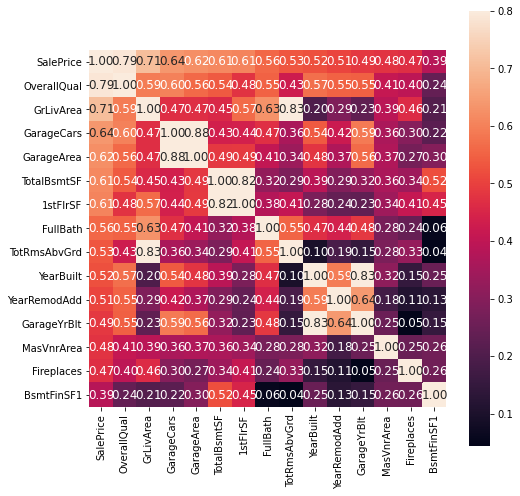

In [7]:
corrmat_top15=train_n[top15_cols].corr()
fig1,ax1=plt.subplots(figsize=(8,8))
sns.heatmap(corrmat_top15,vmax=.8, square=True,ax=ax1,annot=True, fmt='.2f', annot_kws={'size': 12})

**Co-linearity**:

We will choose only one feature from each co-linear pair.

* GarageCars and GarageArea 
* TotalBsmtSF and 1stFirSF 
* TotRmsAbvGrd and GrLIveArea 

>I choose GarageArea,TotalBsmtSF,GrLIveArea.I have made this decision by plotting below scatter plots.

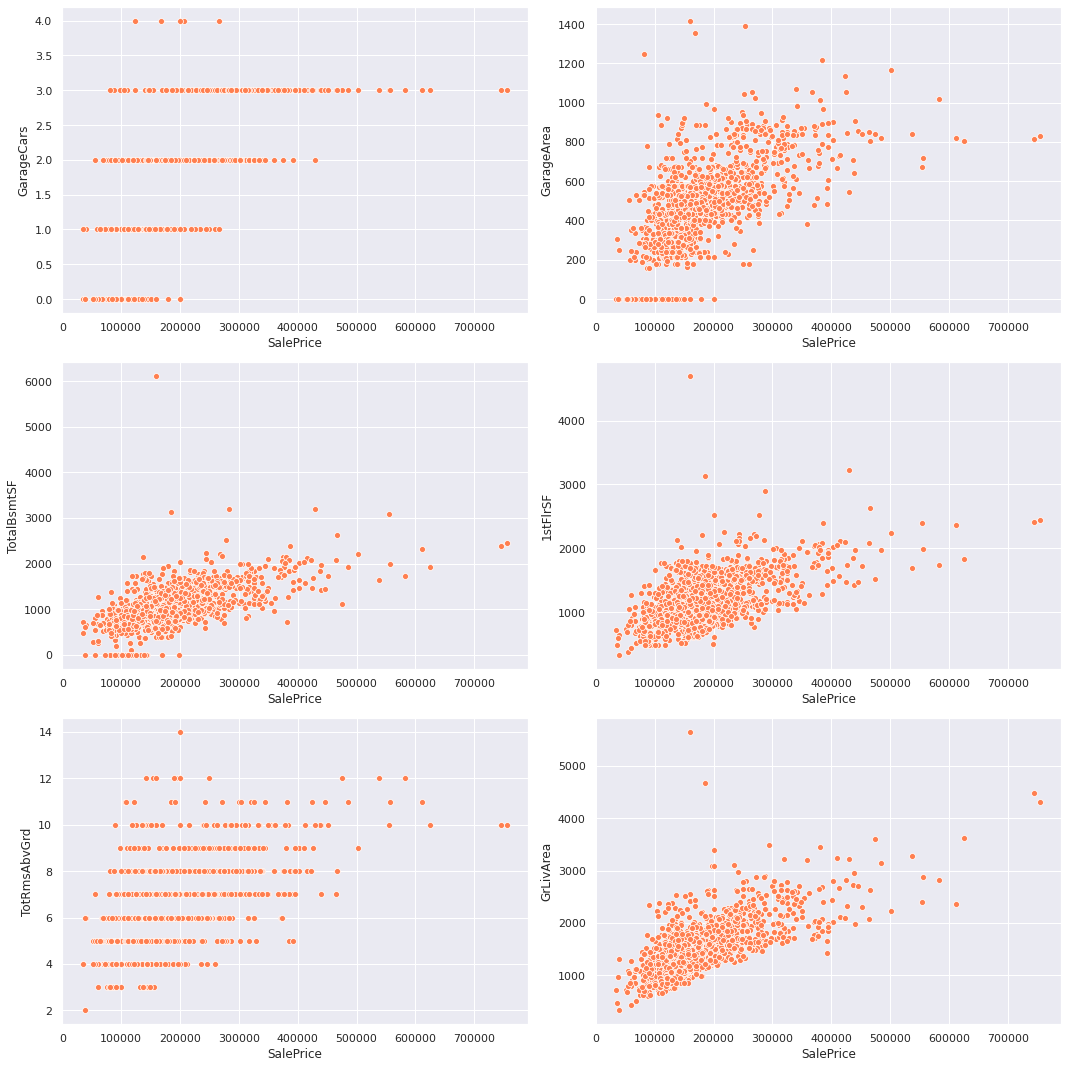

In [8]:
sns.set(style="darkgrid")

fig,ax=plt.subplots(3,2,figsize=(15,15))
sns.scatterplot(train_n['SalePrice'],train_n['GarageCars'],ax=ax[0][0],color='coral')
sns.scatterplot(train_n['SalePrice'],train_n['GarageArea'],ax=ax[0][1],color='coral')
sns.scatterplot(train_n['SalePrice'],train_n['TotalBsmtSF'],ax=ax[1][0],color='coral')
sns.scatterplot(train_n['SalePrice'],train_n['1stFlrSF'],ax=ax[1][1],color='coral')
sns.scatterplot(train_n['SalePrice'],train_n['TotRmsAbvGrd'],ax=ax[2][0],color='coral')
sns.scatterplot(train_n['SalePrice'],train_n['GrLivArea'],ax=ax[2][1],color='coral')
fig.tight_layout()

In [9]:
# sns.jointplot(x=train['OverallQual'], y=train['SalePrice'], kind='reg',color='skyblue',height=7)

In [10]:
train_n1=train_n.drop(['GarageCars','1stFlrSF','TotRmsAbvGrd'],axis=1)
test_n1=test_n.drop(['GarageCars','1stFlrSF','TotRmsAbvGrd'],axis=1)

We have removed co-linearity from our dataset, Now we will manually examine each feature and remove non-linear features from the dataset

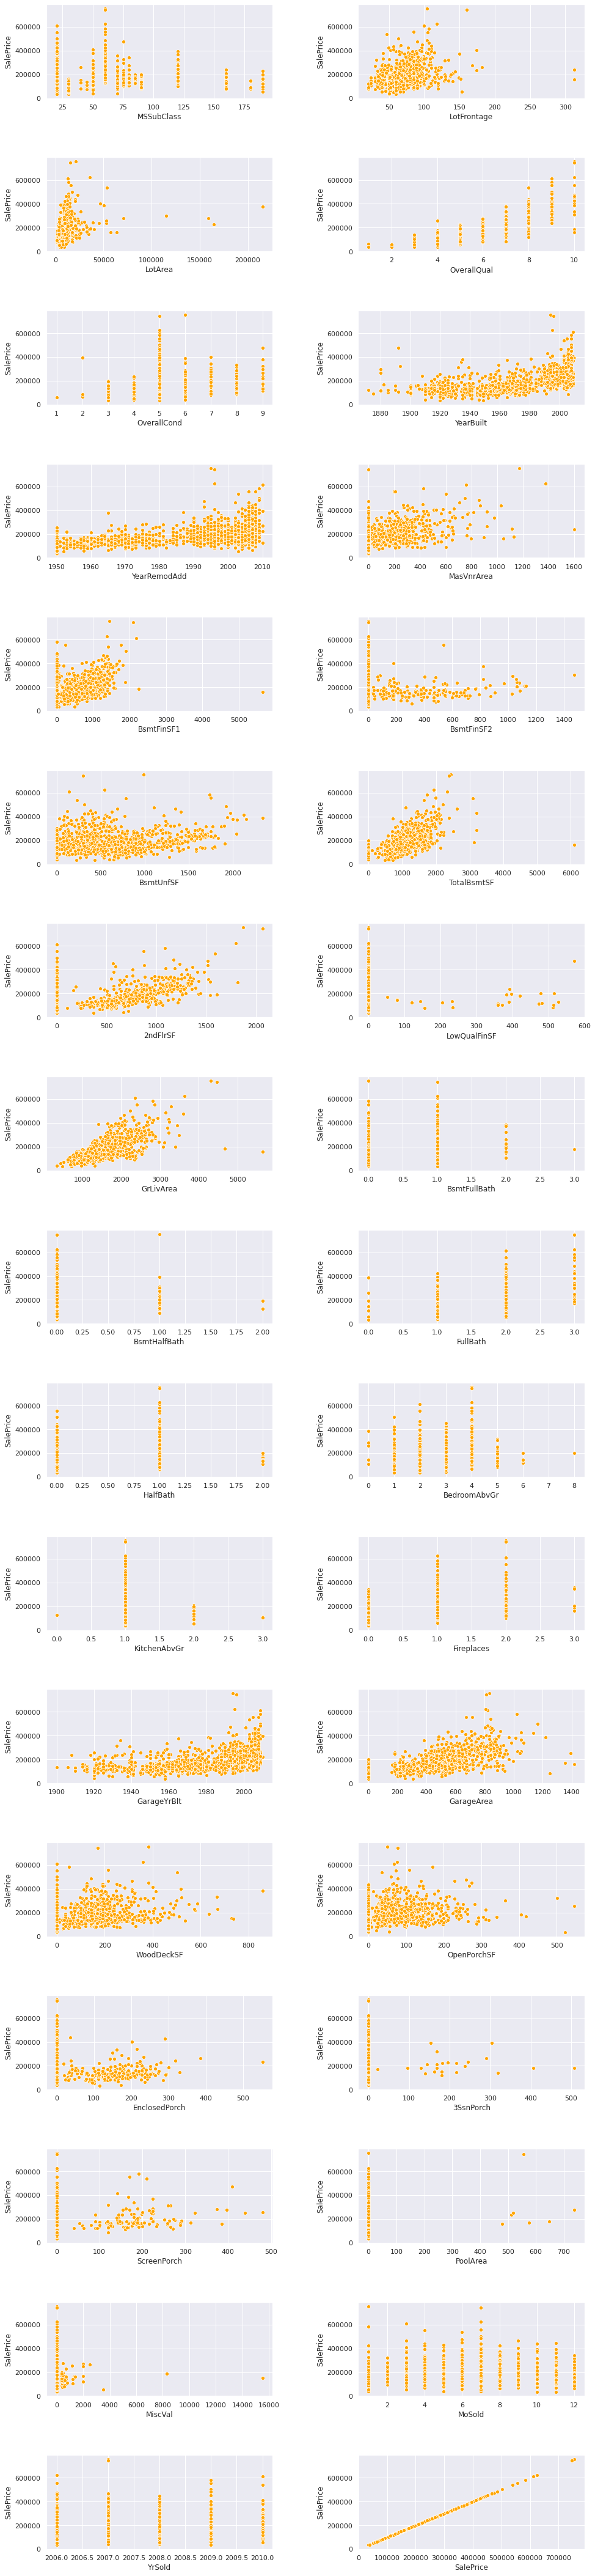

In [11]:
fig,ax=plt.subplots(17,2,figsize=(15,60))
def graph(x,y,r,c,title):
    sns.scatterplot(train_n1[x],y,color=('orange'),ax=ax[r][c])
    ax[r][c].set_xlabel(x)
    fig.tight_layout(pad=5.0)

for r,col in enumerate(train_n1.columns):
    c=r%2
    graph(col,train['SalePrice'],r//2,c,col)


<div>
Some features are like categorical features.
    <br><br>e.g.,OverallCond,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,Fireplaces,KitchenAbrGr,MoSold,YrSold.
<br>
<br>
Although their type is Integer, We would treat them as a categorical feature in the next section [2.EDA on Categorical Features](#intLink)
</div>

In [12]:
non_linear=['MSSubClass','LotArea','OverallCond','LowQualFinSF','BsmtFullBath', 'BsmtHalfBath','FullBath', 'HalfBath','BedroomAbvGr',
            'KitchenAbvGr','Fireplaces','3SsnPorch','ScreenPorch' ,'PoolArea','MiscVal','MoSold', 'YrSold']
print("total non-linear",len(non_linear)," columns")

total non-linear 17  columns


In [13]:
linear_features=np.array([col for col in train_n1.columns if col not in non_linear])

We have removed some non-linear features from the dataset

**1.2 Misssing Values**

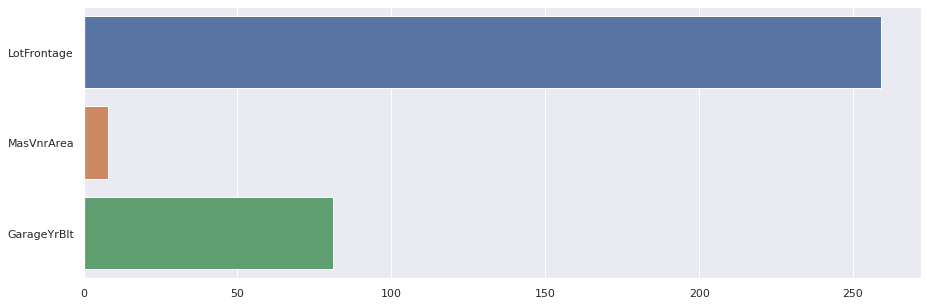

In [14]:
# sns.set(style="whitegrid")
fig=plt.figure(figsize=(15,5))
train_null=train_n1.isnull().sum()[train_n1.isnull().sum()!=0]
sns.barplot(y=train_null.index,x=train_null)

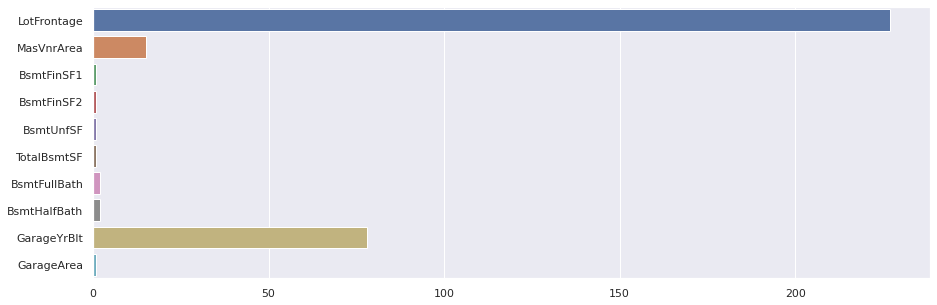

In [15]:
# sns.set(style="whitegrid")
fig=plt.figure(figsize=(15,5))
test_null=test_n1.isnull().sum()[test_n1.isnull().sum()!=0]
sns.barplot(y=test_null.index,x=test_null)

In [16]:
train_n1['GarageYrBlt']=train_n1['GarageYrBlt'].fillna(train_n1['GarageYrBlt'].median())
test_n1['GarageYrBlt']=test_n1['GarageYrBlt'].fillna(test_n1['GarageYrBlt'].median())

for col in train_n1.columns:
    train_n1[col] = train_n1[col].fillna(0)
for col in test_n1.columns:
    test_n1[col] = test_n1[col].fillna(0)

In [17]:
print(train_n1[linear_features].shape)
print(test_n1[linear_features[:-1]].shape)

(1460, 17)
(1459, 16)


In [18]:
train_n1.isnull().sum()[train_n1.isnull().sum()!=0]

Series([], dtype: int64)

In [19]:
test_n1.isnull().sum()[test_n1.isnull().sum()!=0]

Series([], dtype: int64)

**1.3 Feature Generation**

In [20]:
# fig,ax=plt.subplots(9,2,figsize=(15,40))
# def graph(x,y,r,c,title):
#     sns.scatterplot(train_n1[x],train_n1[y],color=('red'),ax=ax[r][c])
#     ax[r][c].set_ylabel(y)
#     ax[r][c].set_xlabel(x)
#     fig.tight_layout(pad=5.0)

# for r,col in enumerate(train_n1[linear_features].columns):
#     c=r%2
#     graph(col,'SalePrice',r//2,c,col)

>* We can clearly see in the above graphs that features have so many zeros.
>* That means many missing values are filled with zero.

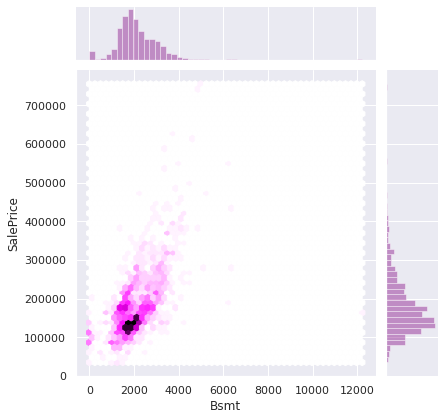

In [21]:
train_n1['Bsmt']=train_n1['BsmtFinSF1']+train_n1['BsmtFinSF2']+train_n1['BsmtUnfSF']+train_n1['TotalBsmtSF']
test_n1['Bsmt']=test_n1['BsmtFinSF1']+test_n1['BsmtFinSF2']+test_n1['BsmtUnfSF']+test_n1['TotalBsmtSF']
sns.jointplot(train_n1['Bsmt'],train_n1['SalePrice'],kind='hex',color='purple')
# sns.jointplot(train_n1['BsmtFinSF1'],train_n1['SalePrice'],kind='reg',color='green')

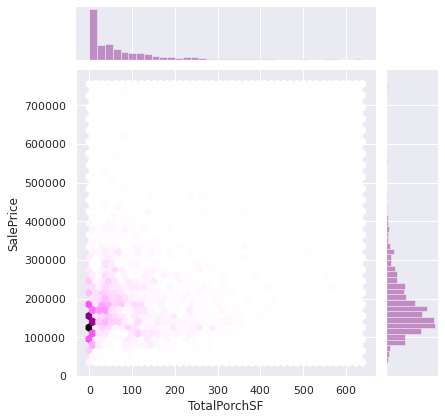

In [22]:
train_n1['TotalPorchSF']=train_n1['EnclosedPorch']+train_n1['OpenPorchSF']
test_n1['TotalPorchSF']=test_n1['EnclosedPorch']+test_n1['OpenPorchSF']

sns.jointplot(train_n1['TotalPorchSF'],train_n1['SalePrice'],kind='hex',color='purple')

But this new TotalPorchSF feature is not linear with SalePrice so we will not use it .

In [23]:
linear_features

array(['LotFrontage', 'OverallQual', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '2ndFlrSF', 'GrLivArea', 'GarageYrBlt',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
       'SalePrice'], dtype='<U13')

In [24]:
linear_features=['LotFrontage', 'OverallQual', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea','Bsmt', '2ndFlrSF', 'GrLivArea', 'GarageYrBlt',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch']

In [25]:
train_n1[linear_features].columns

Index(['LotFrontage', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'Bsmt', '2ndFlrSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch'],
      dtype='object')

In [26]:
train_n1[linear_features].shape

(1460, 13)

In [27]:
test_n1[linear_features].shape

(1459, 13)

**1.4 Outliers**

>Outliers:

     LotFrontage > 300 
     MasVnrArea > 1200
     Bsmt > 12000
     GrLivArea > 4600
     GarageArea > 1200
     SalePrice > 700000

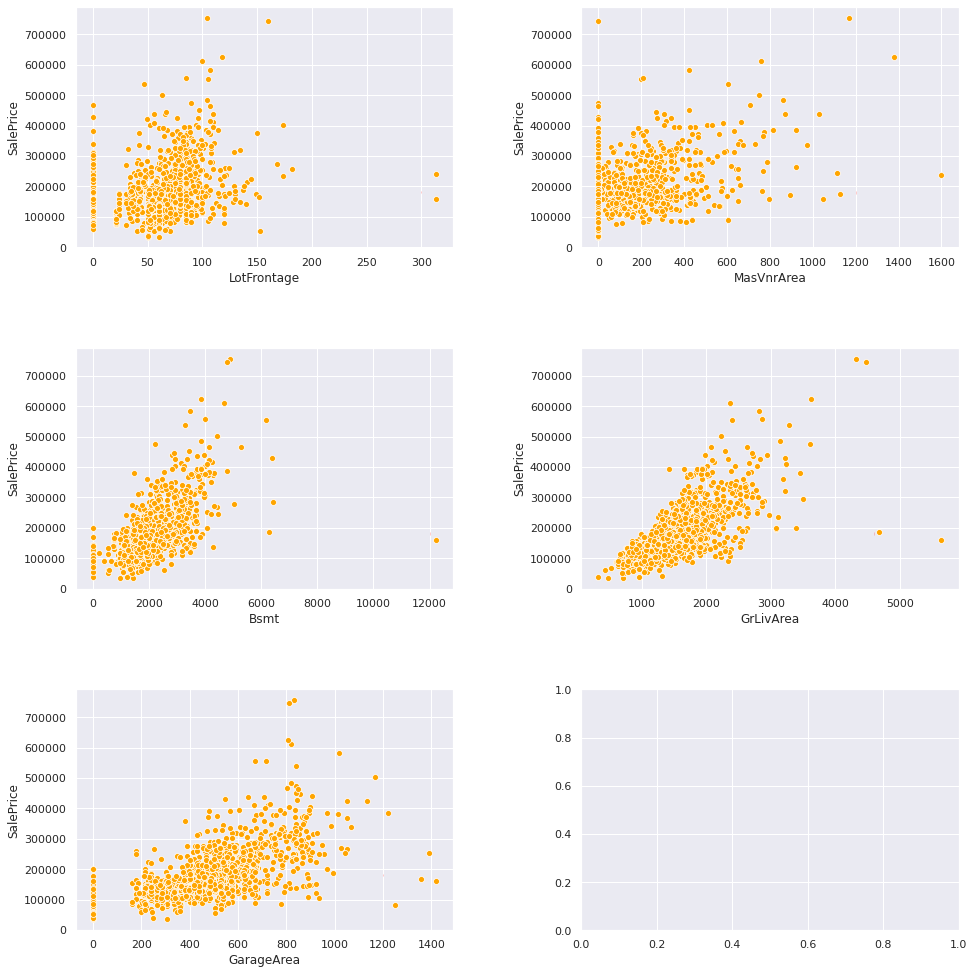

In [28]:
fig,ax=plt.subplots(3,2,figsize=(15,15))
def graph(x,y,r,c,title,line):
    sns.scatterplot(train_n1[x],train_n1[y],color=('orange'),ax=ax[r][c])
    sns.lineplot(x=line,y=train_n1[y],color='red',ax=ax[r][c])
    ax[r][c].set_ylabel(y)
    ax[r][c].set_xlabel(x)
    fig.tight_layout(pad=5.0)

out=[300,1200,12000,4600,1200]
for r,col in enumerate(np.array(['LotFrontage','MasVnrArea','Bsmt','GrLivArea','GarageArea'])):
    c=r%2
    graph(col,'SalePrice',r//2,c,col,out[r])

In [29]:
a=train_n1['LotFrontage'].sort_values(ascending=False).head(2)
b=train_n1['MasVnrArea'].sort_values(ascending=False).head(2)
c=train_n1['Bsmt'].sort_values(ascending=False).head(1)
d=train_n1['GrLivArea'].sort_values(ascending=False).head(2)
e=train_n1['GarageArea'].sort_values(ascending=False).head(3)
f=train_n1['SalePrice'].sort_values(ascending=False).head(2)

In [30]:
index=a.index
index=index.append(b.index)
index=index.append(c.index)
index=index.append(d.index)
index=index.append(e.index)
index=index.append(f.index)

In [31]:
train_n1=train_n1.drop(index).reset_index(drop=True)

>we have removed the outliears manually

In [32]:
# fig,ax=plt.subplots(7,2,figsize=(15,30))
# def graph(x,y,r,c,title):
#     sns.regplot(train_n1[x],train_n1[y],color=('green'),ax=ax[r][c])
#     ax[r][c].set_ylabel(y)
#     ax[r][c].set_xlabel(x)
#     fig.tight_layout(pad=5.0)

# for r,col in enumerate(train_n1[linear_features].columns):
#     c=r%2
#     graph(col,'SalePrice',r//2,c,col)

In [33]:
print(train_n1.shape)
print(train_n1[linear_features].shape)

(1451, 36)
(1451, 13)


**1.5 Skewing the features**

In [34]:
Train_X_n=train_n1[linear_features]
Train_Y_n=train_n1['SalePrice']

In [35]:
Train_X_n.skew()

LotFrontage     -0.304896
OverallQual      0.178474
YearBuilt       -0.608484
YearRemodAdd    -0.496830
MasVnrArea       2.300035
Bsmt             0.483762
2ndFlrSF         0.766328
GrLivArea        0.811428
GarageYrBlt     -0.674187
GarageArea       0.047691
WoodDeckSF       1.555968
OpenPorchSF      2.339160
EnclosedPorch    3.077668
dtype: float64

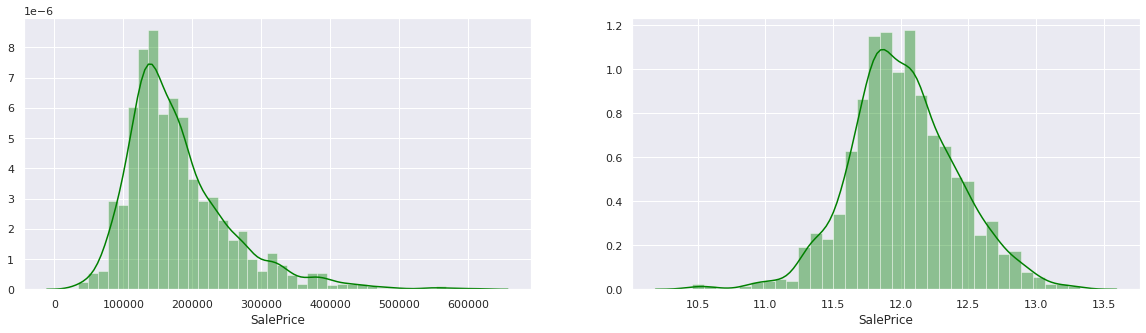

In [36]:
fig,ax=plt.subplots(1,2,figsize=(20,5))
sns.distplot(Train_Y_n,ax=ax[0],color='green')
sns.distplot(np.log1p(Train_Y_n),ax=ax[1],color='green')
# fig.tight_layout()

In [37]:
y_train=np.log1p(Train_Y_n)

**1.6 scaling**

In [38]:
# scaler=StandardScaler()
scaler=RobustScaler()
final_train_n=pd.DataFrame(scaler.fit_transform(Train_X_n),columns=Train_X_n.columns)
final_test_n=pd.DataFrame(scaler.fit_transform(test_n1[linear_features]),columns=Train_X_n.columns)

In [39]:
final_train_n.head()

,LotFrontage,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,Bsmt,2ndFlrSF,GrLivArea,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch
0,0.054795,0.5,0.673913,0.263158,1.209877,-0.269618,1.173077,0.394104,0.589744,0.281690,0.000000,0.544118,0.0
1,0.465753,0.0,0.086957,-0.447368,0.000000,0.547284,0.000000,-0.301009,-0.102564,-0.072435,1.773810,-0.352941,0.0
2,0.136986,0.5,0.630435,0.236842,1.000000,-0.140845,1.189560,0.512025,0.538462,0.523139,0.000000,0.264706,0.0
3,-0.082192,0.5,-1.239130,-0.605263,0.000000,-0.470825,1.038462,0.404965,0.461538,0.659960,0.000000,0.161765,272.0
4,0.575342,1.0,0.608696,0.184211,2.160494,0.311871,1.446429,1.151280,0.512821,1.440644,1.142857,0.882353,0.0


In [40]:
final_test_n.head()

,LotFrontage,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,Bsmt,2ndFlrSF,GrLivArea,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch
0,0.500000,-0.5,-0.250000,-0.756098,0.000000,-0.203846,0.000000,-0.888152,-0.444444,0.967118,0.833333,-0.388889,0.0
1,0.529412,0.0,-0.312500,-0.829268,0.666667,0.655769,0.000000,-0.170671,-0.518519,-0.649903,2.339286,0.111111,0.0
2,0.323529,-0.5,0.500000,0.146341,0.000000,-0.115385,1.036982,0.326429,0.444444,0.007737,1.261905,0.083333,0.0
3,0.441176,0.0,0.520833,0.146341,0.123457,-0.119231,1.002959,0.285004,0.469136,-0.038685,2.142857,0.111111,0.0
4,-0.588235,1.0,0.395833,0.000000,0.000000,0.561538,0.000000,-0.251864,0.320988,0.100580,0.000000,0.750000,0.0


# 2. **EDA on Categorical Features**

**2.1 Missing values **

In [41]:
train_c=train[[c for c in train.columns if train[c].dtypes=='O']].copy()
test_c=test[[c for c in test.columns if test[c].dtypes=='O']].copy()

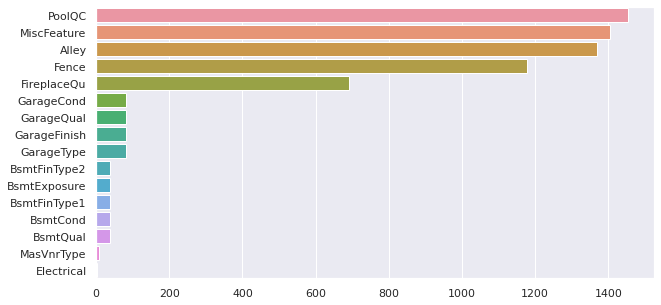

In [42]:
# print(train_c.shape)
fig=plt.figure(figsize=(10,5))
train_null=train_c.isnull().sum()[train_c.isnull().sum()!=0].sort_values(ascending=False)
sns.barplot(y=train_null.index,x=train_null)

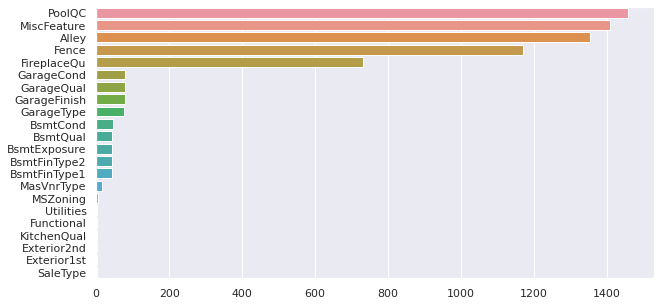

In [43]:
fig=plt.figure(figsize=(10,5))
test_null=test_c.isnull().sum()[test_c.isnull().sum()!=0].sort_values(ascending=False)
sns.barplot(y=test_null.index,x=test_null)

Drop first five columns 

In [44]:
train_c.dropna(thresh=len(train_c)*0.9,axis=1,inplace=True)

In [45]:
test_c.dropna(thresh=len(test_c)*0.9,axis=1,inplace=True)

In [46]:
train_c['Electrical']=train_c['Electrical'].fillna(method='ffill')
test_c['SaleType']=test_c['SaleType'].fillna(method='ffill')
test_c['KitchenQual']=test_c['KitchenQual'].fillna(method='ffill')
test_c['Exterior1st']=test_c['Exterior1st'].fillna(method='ffill')
test_c['Exterior2nd']=test_c['Exterior2nd'].fillna(method='ffill')
test_c['Functional']=test_c['Functional'].fillna(method='ffill')
test_c['Utilities']=test_c['Utilities'].fillna(method='ffill')
test_c['MSZoning']=test_c['MSZoning'].fillna(method='ffill')


In [47]:
# Categorical missing values
for col in train_c.columns:
    train_c[col] = train_c[col].fillna("None")
for col in test_c.columns:
    test_c[col] = test_c[col].fillna("None")

In [48]:
print("Train null values : ",len(train_c.isnull().sum()[train_c.isnull().sum()!=0]))
print("Test null values : ",len(test_c.isnull().sum()[test_c.isnull().sum()!=0]))

Train null values :  0
Test null values :  0


In [49]:
train_c=train_c.drop(index).reset_index(drop=True)
train_c.shape

(1451, 38)

In [50]:
test_c.shape

(1459, 38)

<div id="intLink">
**2.2 Feature engineering**
    </div>

We had discussed about some numerical features which looked like categorical features. Now we will work on it in this section

In [51]:
num_train=train_n1[['OverallCond','BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath','KitchenAbvGr',
'BedroomAbvGr','Fireplaces','MoSold','YrSold']]
num_test=test_n1[['OverallCond','BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath','KitchenAbvGr',
'BedroomAbvGr','Fireplaces','MoSold','YrSold']]
print(num_train.shape)
print(num_test.shape)
numerical_categorical_feature=c = pd.concat((num_train,num_test),sort=False)
print(numerical_categorical_feature.shape)
numerical_categorical_feature=numerical_categorical_feature.astype('O')

(1451, 10)
(1459, 10)
(2910, 10)


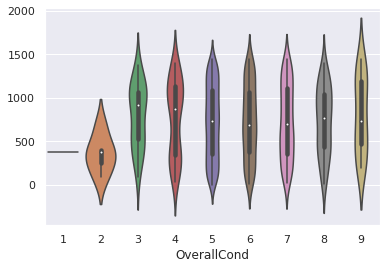

In [52]:
sns.violinplot(x=num_train['OverallCond'],y=num_train['OverallCond'].index)

In [53]:
numerical_categorical_feature=pd.get_dummies(numerical_categorical_feature)
num_train_dummy=numerical_categorical_feature[:1451]
num_test_dummy=numerical_categorical_feature[1451:].reset_index(drop=True)
print(num_train_dummy.shape)
print(num_test_dummy.shape)

(1451, 58)
(1459, 58)


**2.3 Get Dummies**

In [54]:
c = pd.concat((train_c, test_c), sort=False).reset_index(drop=True)

In [55]:
c1=pd.get_dummies(c)

In [56]:
final_train_c=c1.iloc[:train_c.shape[0]]
# final_train_c=final_train_c.drop(index).reset_index(drop=True)
final_train_c.shape

(1451, 242)

In [57]:
final_test_c=c1.iloc[train_c.shape[0]:]
final_test_c=final_test_c.reset_index(drop=True)
final_test_c.shape

(1459, 242)

**2.4 merge the numerical_categorical_feature with final_test_c**

In [58]:
final_train_c=final_train_c.merge(num_train_dummy,left_index=True,right_index=True)
final_test_c=final_test_c.merge(num_test_dummy,left_index=True,right_index=True)

**2.5 Labeling only for XGB Regressor**

In [59]:
train_c_labeled=pd.DataFrame()
test_c_labeled=pd.DataFrame()

for col in train_c.columns:
    le = preprocessing.LabelEncoder()
    train_c_labeled[col]=le.fit_transform(train_c[col])
    test_c_labeled[col]=le.fit_transform(test_c[col])

In [60]:
test_c_labeled

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,2,1,3,3,0,4,0,12,1,2,...,3,3,6,1,3,4,5,2,8,4
1,3,1,0,3,0,0,0,12,2,2,...,3,2,6,1,3,4,5,2,8,4
2,3,1,0,3,0,4,0,8,2,2,...,3,3,6,1,0,4,5,2,8,4
3,3,1,0,3,0,4,0,8,2,2,...,3,2,6,1,0,4,5,2,8,4
4,3,1,0,1,0,4,0,22,2,2,...,3,2,6,1,2,4,5,2,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,4,1,3,3,0,4,0,10,2,2,...,3,3,6,6,1,2,3,2,8,4
1455,4,1,3,3,0,4,0,10,2,2,...,3,3,6,4,3,4,5,2,8,0
1456,3,1,3,3,0,4,0,11,2,2,...,3,3,6,5,3,4,5,2,8,0
1457,3,1,3,3,0,4,0,11,2,2,...,3,3,6,6,1,2,3,2,8,4


In [61]:
final_test_n

,LotFrontage,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,Bsmt,2ndFlrSF,GrLivArea,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch
0,0.500000,-0.5,-0.250000,-0.756098,0.000000,-0.203846,0.000000,-0.888152,-0.444444,0.967118,0.833333,-0.388889,0.0
1,0.529412,0.0,-0.312500,-0.829268,0.666667,0.655769,0.000000,-0.170671,-0.518519,-0.649903,2.339286,0.111111,0.0
2,0.323529,-0.5,0.500000,0.146341,0.000000,-0.115385,1.036982,0.326429,0.444444,0.007737,1.261905,0.083333,0.0
3,0.441176,0.0,0.520833,0.146341,0.123457,-0.119231,1.002959,0.285004,0.469136,-0.038685,2.142857,0.111111,0.0
4,-0.588235,1.0,0.395833,0.000000,0.000000,0.561538,0.000000,-0.251864,0.320988,0.100580,0.000000,0.750000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,-1.235294,-1.0,-0.062500,-0.536585,0.000000,-0.850000,0.807692,-0.563380,0.000000,-1.856867,0.000000,-0.388889,0.0
1455,-1.235294,-1.0,-0.062500,-0.536585,0.000000,-0.850000,0.807692,-0.563380,-0.222222,-0.750484,0.000000,-0.055556,0.0
1456,2.852941,-0.5,-0.270833,0.097561,0.000000,0.453846,0.000000,-0.344656,-0.469136,0.371373,2.821429,-0.388889,0.0
1457,-0.029412,-0.5,0.395833,0.000000,0.000000,-0.146154,0.000000,-0.765534,0.000000,-1.856867,0.476190,0.055556,0.0


# 3. Merging numerical and categorical data

In [62]:
x_train=final_train_n.merge(final_train_c,left_index=True,right_index=True).reset_index(drop=True)
x_test=final_test_n.merge(final_test_c,left_index=True,right_index=True).reset_index(drop=True)

**Merging for XGB Regressor**

In [63]:
x_train_xgb=final_train_n.merge(train_c_labeled,left_index=True,right_index=True).reset_index(drop=True)
x_test_xgb=final_test_n.merge(test_c_labeled,left_index=True,right_index=True).reset_index(drop=True)

In [64]:
print(x_train.shape)
print(x_test.shape)
print(x_train_xgb.shape)
print(x_test_xgb.shape)

(1451, 313)
(1459, 313)
(1451, 51)
(1459, 51)


# 4. Splitting data into training and testing data

In [65]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train,test_size = .3, random_state=0)

# 5. **Regularization and Evaluation**

**5.1 Ridge**

In [66]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

ridge=Ridge()
parameters= {'alpha':[x for x in [0.1,0.2,0.4,0.5,0.7,0.8,1]]}

ridge_reg=GridSearchCV(ridge, param_grid=parameters)
ridge_reg.fit(X_train,Y_train)
print("The best value of Alpha is: ",ridge_reg.best_params_)

The best value of Alpha is:  {'alpha': 1}


In [67]:
ridge_mod=Ridge(alpha=1)
ridge_mod.fit(x_train,y_train)
y_pred_train=ridge_mod.predict(X_train)
y_pred_test=ridge_mod.predict(X_test)

print('Root Mean Square Error train = ' + str(np.sqrt(mean_squared_error(Y_train, y_pred_train))))
print('Root Mean Square Error test = ' + str(np.sqrt(mean_squared_error(Y_test, y_pred_test)))) 

Root Mean Square Error train = 0.09293632684288554
Root Mean Square Error test = 0.09449830158697793


**5.2 Lasso**

In [68]:
from sklearn.linear_model import Lasso

Lasso_reg =Lasso()
parameters= {'alpha':[x for x in [0.0005,0.001,0.01,0.1,1]]}

Lasso_reg=GridSearchCV(Lasso_reg, param_grid=parameters)
Lasso_reg.fit(X_train,Y_train)
print("The best value of Alpha is: ",Lasso_reg.best_params_,Lasso_reg.best_score_)

The best value of Alpha is:  {'alpha': 0.0005} 0.9104352912144644


In [69]:
Lasso_reg =Lasso(alpha=0.0005)
Lasso_reg.fit(x_train,y_train)
y_pred_train=Lasso_reg.predict(X_train)
y_pred_test=Lasso_reg.predict(X_test)

print('Root Mean Square Error train = ' + str(np.sqrt(mean_squared_error(Y_train, y_pred_train))))
print('Root Mean Square Error test = ' + str(np.sqrt(mean_squared_error(Y_test, y_pred_test)))) 

Root Mean Square Error train = 0.10221397297831313
Root Mean Square Error test = 0.10040464474527822


**5.3 Random Forest Regressor**

In [70]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
params = {"max_depth":[15,20,25], "n_estimators":[27,30,33]}
rf_reg = GridSearchCV(rf, params, cv = 10, n_jobs =10)
rf_reg.fit(X_train, Y_train)
print(rf_reg.best_estimator_)
best_estimator=rf_reg.best_estimator_
y_pred_train = best_estimator.predict(X_train)
y_pred_test = best_estimator.predict(X_test)

print('Root Mean Square Error train = ' + str(np.sqrt(mean_squared_error(Y_train, y_pred_train))))
print('Root Mean Square Error test = ' + str(np.sqrt(mean_squared_error(Y_test, y_pred_test)))) 

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=25, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=27, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
Root Mean Square Error train = 0.0574022413397101
Root Mean Square Error test = 0.15432726071478417


**5.4 XGB Regressor**

In [71]:
X_train_xgb, X_test_xgb, Y_train_xgb, Y_test_xgb = train_test_split(x_train_xgb,y_train,test_size = 0.3, random_state=0)

In [72]:
import xgboost as xgb

xgbr = xgb.XGBRegressor()
params = {'learning_rate': [0.10,0.14,0.15,0.16, 0.2], 'max_depth': [1,2,3,5] }

xgbr_reg = GridSearchCV(xgbr, params, cv = 10, n_jobs =1)
xgbr_reg.fit(X_train_xgb,Y_train_xgb)

print("Best params:{}".format(xgbr_reg.best_params_))

best_x = xgbr_reg.best_estimator_
y_train_pred_x = best_x.predict(X_train_xgb)
y_val_pred_x = best_x.predict(X_test_xgb)

Best params:{'learning_rate': 0.15, 'max_depth': 3}


In [73]:
print('Root Mean Square Error train = ' + str(np.sqrt(mean_squared_error(Y_train_xgb, y_train_pred_x))))
print('Root Mean Square Error test = ' + str(np.sqrt(mean_squared_error(Y_test_xgb, y_val_pred_x)))) 

Root Mean Square Error train = 0.07874392486921512
Root Mean Square Error test = 0.1317785438280041


**5.3 Prediction**

Ridge performs better than the Lasso on this dataset

In [74]:
y_test=ridge_mod.predict(x_test)

In [75]:
final_y_test=np.expm1(y_test)

In [76]:
final_y_test

array([120931.54645474, 158393.85865852, 180545.35060096, ...,
       160246.31536444, 118993.85838714, 216814.31839216])

In [77]:
sample=pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv')
submission=pd.DataFrame({"Id":sample['Id'],
                         "SalePrice":final_y_test})
submission.to_csv('submission.csv',index=False)

In [78]:
submission.head()

,Id,SalePrice
0,1461,120931.546455
1,1462,158393.858659
2,1463,180545.350601
3,1464,200187.182524
4,1465,189962.853431
